# Cubs lineup analysis

By [Ben Welsh](https://palewi.re/who-is-ben-welsh/)

A lookup at the lineups selected by Chicago Cubs Manager Joe Maddon during the 2018 baseball season.

In [56]:
import pandas as pd
import altair as alt
import altair_latimes as lat

In [57]:
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

In [58]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
pd.set_option('display.max_colwidth', -1)

In [12]:
df = pd.read_csv("./input/CHC_batting_orders_all.csv").set_index("number")

### How many distinct lineups have been used?

In [13]:
def create_id(row):
    return '-'.join(row[[
        'one',
        'two',
        'three',
        'four',
        'five',
        'six',
        'seven',
        'eight',
        'nine'
    ]])

In [14]:
df['id'] = df.apply(create_id, axis=1)

### By year

In [55]:
lineups_by_year = df.groupby(['year', 'id']).size().reset_index(name='lineups').groupby(['year']).size().reset_index(name="lineups")

In [66]:
lineups_by_year['manager'] = lineups_by_year.year.apply(
    lambda x: 'Joe Maddon' if x >= 2015 else 'Somebody else'
)

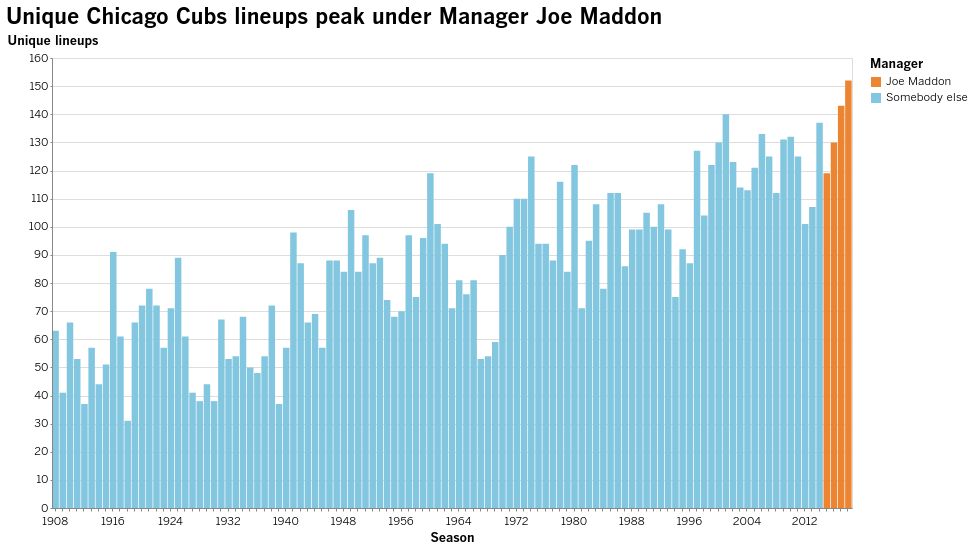

In [76]:
alt.Chart(lineups_by_year).mark_bar().encode(
    x=alt.X(
        "year:O",
        title="Season"
    ),
    y=alt.Y(
        "lineups:Q",
        title="Unique lineups"
    ),
    color=alt.Color(
        "manager:N",
        title="Manager",
        scale=alt.Scale(
            domain=['Joe Maddon', 'Somebody else'],
            range=[lat.palette['highlight'], lat.palette['default']]
        )
    )
).properties(
    width=800,
    title="Unique Chicago Cubs lineups peak under Manager Joe Maddon"
)

### 2018

In [16]:
df_2018 = df[df.year == 2018]

In [17]:
df_2018.head()

,year,one,two,three,four,five,six,seven,eight,nine,id
number,,,,,,,,,,,
1,2018,Happ,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,Baez,pitcher,Happ-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-Baez-pitcher
2,2018,Almora,Bryant,Rizzo,Contreras,Schwarber,Russell,Zobrist,Baez,pitcher,Almora-Bryant-Rizzo-Contreras-Schwarber-Russell-Zobrist-Baez-pitcher
3,2018,Happ,Bryant,Rizzo,Contreras,Schwarber,Russell,Zobrist,Heyward,pitcher,Happ-Bryant-Rizzo-Contreras-Schwarber-Russell-Zobrist-Heyward-pitcher
4,2018,Almora,Bryant,Rizzo,Russell,Schwarber,Caratini,Heyward,Baez,pitcher,Almora-Bryant-Rizzo-Russell-Schwarber-Caratini-Heyward-Baez-pitcher
5,2018,Happ,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,Baez,pitcher,Happ-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-Baez-pitcher


In [18]:
df_2018.id.describe()

count     163                                                                 
unique    152                                                                 
top       Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher
freq      5                                                                   
Name: id, dtype: object

In [19]:
top_lineups = df_2018.groupby("id").size().rename("games").reset_index().sort_values("games", ascending=False)

In [20]:
top_lineups[top_lineups.games > 1]

,id,games
2,Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher,5
25,Almora-Heyward-Baez-Rizzo-Contreras-Schwarber-Happ-Russell-pitcher,2
72,Murphy-Baez-Rizzo-Zobrist-Heyward-Contreras-Schwarber-pitcher-Bote,2
144,Zobrist-Heyward-Bryant-Rizzo-Contreras-Schwarber-Baez-Almora-pitcher,2
10,Almora-Baez-Rizzo-Contreras-Stella-Schwarber-Russell-Heyward-Happ,2
53,Happ-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-Baez-pitcher,2
106,Rizzo-Bryant-Heyward-Baez-Contreras-Schwarber-Almora-Russell-pitcher,2
15,Almora-Bryant-Rizzo-Baez-Zobrist-Contreras-Bote-pitcher-Russell,2


### Has the lineup in Game 163 against the Brewers ever been used before?

<img src="input/game163.jpg">

In [21]:
game163 = 'Murphy-Zobrist-Baez-Rizzo-Bryant-Schwarber-Heyward-pitcher-Contreras'

In [22]:
df[df.id==game163]

,year,one,two,three,four,five,six,seven,eight,nine,id
number,,,,,,,,,,,
163,2018,Murphy,Zobrist,Baez,Rizzo,Bryant,Schwarber,Heyward,pitcher,Contreras,Murphy-Zobrist-Baez-Rizzo-Bryant-Schwarber-Heyward-pitcher-Contreras


### Has the lineup in the Wild Card Game ever been used before?

<img src="input/wild-card-lineup.jpg">

In [23]:
wildcard = "Zobrist-Bryant-Rizzo-Baez-Almora-Murphy-Contreras-Bote-pitcher"

In [24]:
df[df.id==wildcard]

,year,one,two,three,four,five,six,seven,eight,nine,id
number,,,,,,,,,,,


### When was the most frequent lineup used?

In [25]:
df[df.id == 'Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher']

,year,one,two,three,four,five,six,seven,eight,nine,id
number,,,,,,,,,,,
16,2018,Almora,Baez,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,pitcher,Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher
17,2018,Almora,Baez,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,pitcher,Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher
25,2018,Almora,Baez,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,pitcher,Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher
49,2018,Almora,Baez,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,pitcher,Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher
52,2018,Almora,Baez,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,pitcher,Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher


### How many times has the pitcher batted ninth?

In [27]:
len(df_2018[df_2018.nine == 'pitcher'])

99

In [28]:
len(df_2018[df_2018.eight == 'pitcher'])

54

In [30]:
df_2018.nine.describe()

count     163    
unique    8      
top       pitcher
freq      99     
Name: nine, dtype: object

In [31]:
df_2018.nine.value_counts()

pitcher      99
Happ         18
Russell      16
Bote         15
Almora       7 
Caratini     4 
Stella       3 
Contreras    1 
Name: nine, dtype: int64

### Who are the most frequent batters at the other positions?

In [32]:
df_2018.eight.value_counts()

pitcher      54
Heyward      25
Happ         21
Russell      20
Baez         12
Gimenez      8 
Caratini     6 
Schwarber    4 
Contreras    4 
Bote         4 
Almora       3 
Stella       2 
Name: eight, dtype: int64

In [33]:
df_2018.seven.value_counts()

Russell      42
Contreras    27
Happ         19
Caratini     15
Baez         15
Heyward      13
Schwarber    9 
Almora       8 
Bote         8 
Zobrist      5 
Stella       1 
Gimenez      1 
Name: seven, dtype: int64

In [34]:
df_2018.six.value_counts()

Schwarber    71
Contreras    16
Russell      14
Happ         13
Caratini     11
Almora       8 
Bote         8 
Baez         7 
Zobrist      6 
Bryant       4 
Heyward      3 
Stella       2 
Name: six, dtype: int64

In [35]:
df_2018.five.value_counts()

Contreras    43
Schwarber    27
Baez         17
Happ         16
Russell      12
Zobrist      11
Almora       8 
Heyward      7 
Stella       7 
Bryant       6 
Bote         5 
Caratini     4 
Name: five, dtype: int64

In [36]:
df_2018.four.value_counts()

Rizzo        67
Baez         31
Contreras    29
Zobrist      17
Heyward      5 
Russell      5 
Bryant       3 
Bote         3 
Murphy       2 
Schwarber    1 
Name: four, dtype: int64

In [37]:
df_2018.three.value_counts()

Rizzo        49
Bryant       36
Zobrist      23
Baez         22
Heyward      21
Bote         4 
Contreras    2 
Schwarber    2 
Almora       2 
Murphy       1 
Stella       1 
Name: three, dtype: int64

In [38]:
df_2018.two.value_counts()

Bryant       43
Baez         37
Heyward      37
Zobrist      19
Almora       12
Schwarber    6 
Stella       5 
Happ         2 
Rizzo        1 
Russell      1 
Name: two, dtype: int64

In [39]:
df_2018.one.value_counts()

Almora       46
Rizzo        31
Murphy       30
Zobrist      27
Happ         13
Bryant       7 
Baez         4 
Stella       3 
Schwarber    1 
Contreras    1 
Name: one, dtype: int64